Select a dataset:
1. Karate Club
2. Les Miserables
3. Florentine Families
Enter your choice (1-3): 2

=== Network Overview ===
Nodes: 77
Edges: 254
Average Clustering Coefficient: 0.573


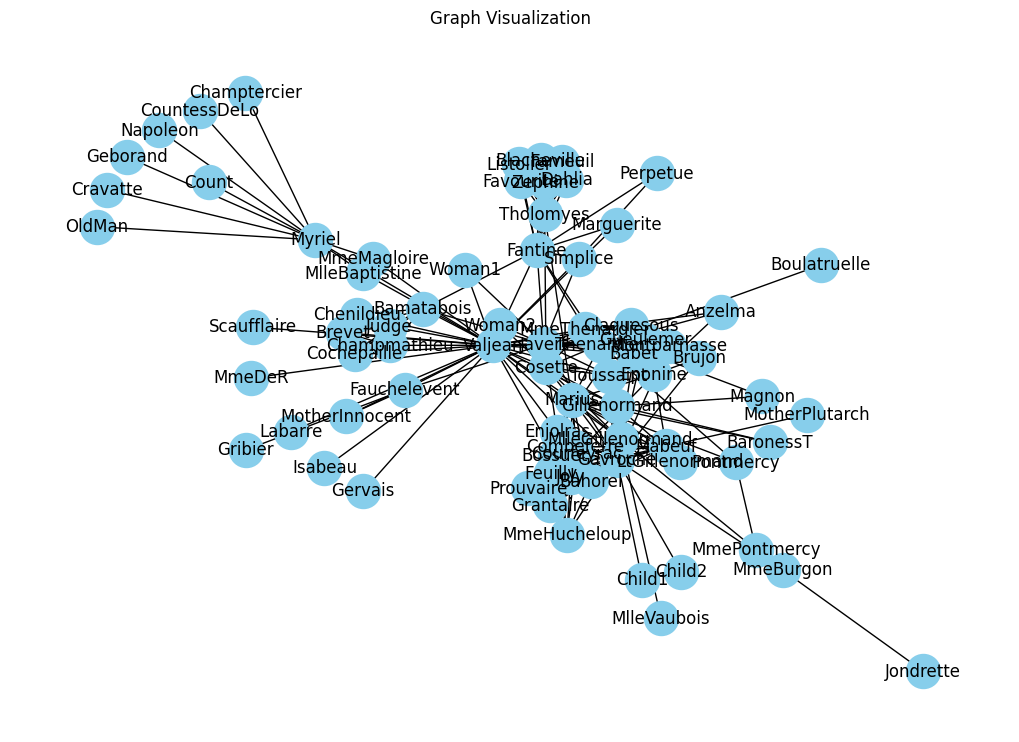

Training edges: 204
Test edges: 50
Test non-edges: 50


TypeError: common_neighbors() missing 1 required positional argument: 'v'

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

class GraphLinkPredictor:
    def __init__(self, dataset='karate'):
        """
        Initialize the class with the given dataset.

        Parameters:
            dataset (str): Dataset name ('karate', 'les', 'florentine')
        """
        dataset_options = {
            'karate': nx.karate_club_graph,
            'les': nx.les_miserables_graph,
            'florentine': nx.florentine_families_graph
        }

        if dataset in dataset_options:
            self.G = dataset_options[dataset]()
        else:
            raise ValueError("Invalid dataset provided")

    def visualize_network(self):
        """Visualize the network structure."""
        print("\n=== Network Overview ===")
        print(f"Nodes: {self.G.number_of_nodes()}")
        print(f"Edges: {self.G.number_of_edges()}")
        print(f"Average Clustering Coefficient: {nx.average_clustering(self.G):.3f}")

        plt.figure(figsize=(10, 7))
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='skyblue', node_size=600)
        plt.title("Graph Visualization")
        plt.show()

    def split_data(self):
        """Split the graph data into training and testing sets."""
        edges = list(self.G.edges())
        np.random.seed(42)
        np.random.shuffle(edges)

        test_size = int(0.2 * len(edges))
        self.test_edges = edges[:test_size]
        self.train_edges = edges[test_size:]

        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(self.test_edges)

        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        self.test_non_edges = non_edges[:test_size]

        print(f"Training edges: {len(self.train_edges)}")
        print(f"Test edges: {len(self.test_edges)}")
        print(f"Test non-edges: {len(self.test_non_edges)}")

    def compute_features(self, graph, u, v):
        """Extract features for a given node pair."""
        features = {
            'Common Neighbors': len(list(nx.common_neighbors(graph, u, v))),
            'Jaccard Coefficient': next(nx.jaccard_coefficient(graph, [(u, v)]), (None, None, 0))[2],
            'Adamic-Adar Index': next(nx.adamic_adar_index(graph, [(u, v)]), (None, None, 0))[2],
            'Preferential Attachment': next(nx.preferential_attachment(graph, [(u, v)]), (None, None, 0))[2],
        }
        return list(features.values())

    def create_dataset(self, graph, positive_edges, negative_edges):
        """Prepare feature matrix and labels."""
        X = [self.compute_features(graph, u, v) for u, v in positive_edges + negative_edges]
        y = [1] * len(positive_edges) + [0] * len(negative_edges)
        return np.array(X), np.array(y)

    def baseline_evaluation(self):
        """Evaluate traditional link prediction methods."""
        methods = {
            'Common Neighbors': nx.common_neighbors,
            'Jaccard Coefficient': nx.jaccard_coefficient,
            'Adamic-Adar Index': nx.adamic_adar_index,
            'Preferential Attachment': nx.preferential_attachment
        }
        results = []

        for method_name, method_func in methods.items():
            pos_scores = [next(method_func(self.train_G, [(u, v)]), (None, None, 0))[2] for u, v in self.test_edges]
            neg_scores = [next(method_func(self.train_G, [(u, v)]), (None, None, 0))[2] for u, v in self.test_non_edges]

            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            auc = roc_auc_score(y_true, y_scores)

            results.append({
                "Method": method_name,
                "AUC": auc
            })

        results_df = pd.DataFrame(results)
        print("\n=== Baseline Method Evaluation ===")
        print(results_df)

    def train_and_evaluate_model(self):
        """Train and evaluate a machine learning model for link prediction."""
        X, y = self.create_dataset(self.train_G, self.test_edges, self.test_non_edges)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)

        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)

        print("\n=== Random Forest Evaluation ===")
        print(f"AUC: {auc:.3f}")

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    def run(self):
        """Execute the full experiment pipeline."""
        self.visualize_network()
        self.split_data()
        self.baseline_evaluation()
        self.train_and_evaluate_model()

if __name__ == "__main__":
    print("Select a dataset:")
    print("1. Karate Club")
    print("2. Les Miserables")
    print("3. Florentine Families")
    dataset_choice = input("Enter your choice (1-3): ")

    dataset_map = {'1': 'karate', '2': 'les', '3': 'florentine'}

    if dataset_choice in dataset_map:
        predictor = GraphLinkPredictor(dataset=dataset_map[dataset_choice])
        predictor.run()
    else:
        print("Invalid selection!")
